# Home assignment 2. StarGAN v2
In this home assignment I built [StarGAN v2](https://arxiv.org/abs/1912.01865) and trained on [CelebA](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset) from scratch.

## Dataset visualization

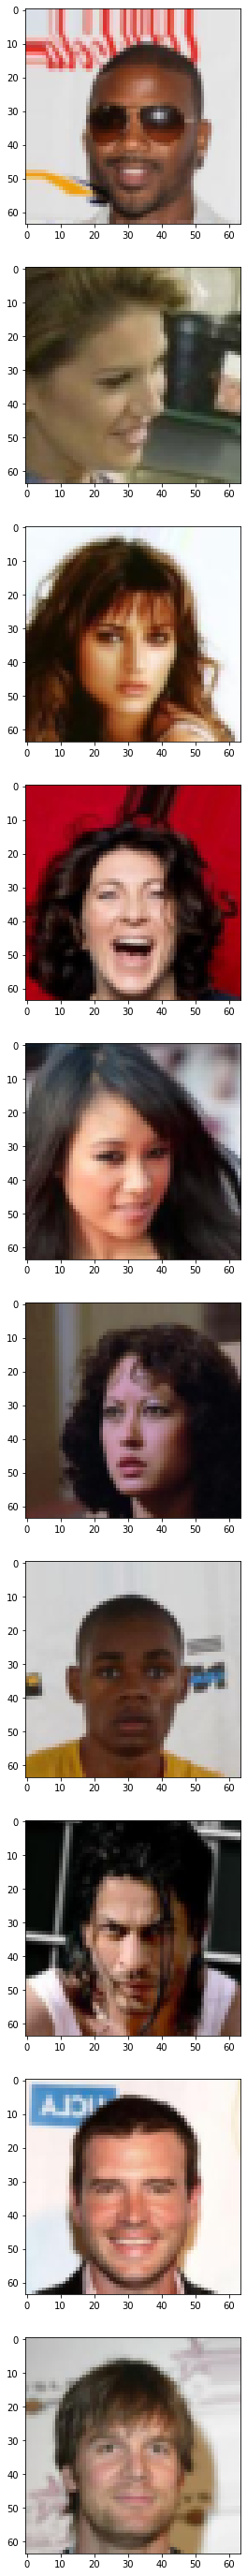

In [3]:
import matplotlib.pyplot as plt
import numpy as np

images_cnt = 10
plt.figure(figsize=(17,images_cnt*5))
dataset = src_loader.dataset
for i, img_idx in enumerate(np.random.choice(range(len(dataset)), images_cnt)):
    img, target = dataset[img_idx]
    img = (img + 1) / 2
    plt.subplot(images_cnt,1,i+1)
    plt.imshow(img.detach().cpu().numpy().transpose(1,2,0))

# Evaluation

In [13]:
lpips = LPIPS()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Downloading: "https://raw.githubusercontent.com/richzhang/PerceptualSimilarity/master/lpips/weights/v0.1/alex.pth" to /root/.cache/torch/hub/checkpoints/alex.pth


  0%|          | 0.00/5.87k [00:00<?, ?B/s]

In [14]:
from tqdm.auto import trange
test_iters = 100
values = []

for i in trange(test_iters):
    # fetch images and labels
    x_real, _ = next(iter(val_loader))
    x_ref, y_trg = next(iter(val_loader))

    x_real, x_ref = x_real.to(device), x_ref.to(device)
    y_trg = y_trg.to(device)

    with torch.no_grad():
        s_trg = nets.style_encoder(x_ref, y_trg)
        x_fake = nets.generator(x_real, s_trg)
    
    values.append(lpips(x_fake.cpu(), x_real.cpu()).squeeze().item())

assert(np.mean(values) < 1.3)

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
# with reference images
np.mean(values)

0.7260599201917648

In [16]:
values = []

for i in trange(test_iters):
    # fetch images and labels
    x_real, _ = next(iter(val_loader))

    batch_size = x_real.shape[0]
    x_real = x_real.to(device)
    z_ref = torch.randn(batch_size, latent_dim).to(device)
    y_trg = torch.randint(0, num_domains, (batch_size,)).to(device)

    with torch.no_grad():
        s_trg = nets.mapping_network(z_ref, y_trg)
        x_fake = nets.generator(x_real, s_trg)
    
    values.append(lpips(x_fake.cpu(), x_real.cpu()).squeeze().item())

assert(np.mean(values) < 1.3)

  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
# with latent vector
np.mean(values)

0.7009119698405266

Real image


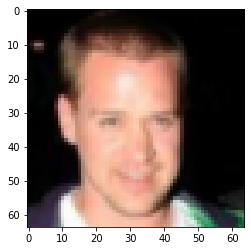

In [21]:
x_real, _ = next(iter(val_loader))
x_ref, y_trg = next(iter(val_loader))
x_real, x_ref, y_trg = x_real.to(device), x_ref.to(device), y_trg.to(device)
with torch.no_grad():
    z_trg = torch.randn((batch_size, latent_dim)).to(device)
    s_trg1 = nets.mapping_network(z_trg, y_trg)
    s_trg2 = nets.style_encoder(x_ref, y_trg)
    x_fake1 = (nets.generator(x_real, s_trg1) + 1) / 2
    x_fake2 = (nets.generator(x_real, s_trg2) + 1) / 2
    x_real = (x_real + 1 ) / 2

print('Real image')
plt.imshow(x_real[1].permute(1,2,0).detach().cpu().numpy());

Fake image generated with latent vector


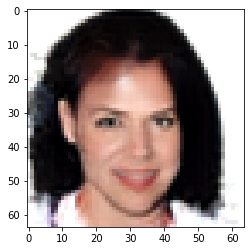

In [22]:
print('Fake image generated with latent vector')
plt.imshow(x_fake1[1].clamp_(0, 1).permute(1,2,0).detach().cpu().numpy());

Fake image generated with reference image


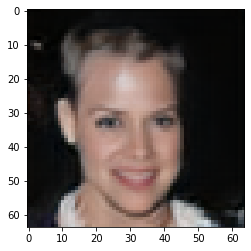

In [23]:
print('Fake image generated with reference image')
plt.imshow(x_fake2[1].clamp_(0, 1).permute(1,2,0).detach().cpu().numpy());

### Latent space analysis and visually qualitative result

I generated two latent vectors for each image and linearly interpolated from the first latent vector to the second one. The result is pretty good.
Intermediate images are changed smoothly between the first and second fake images.

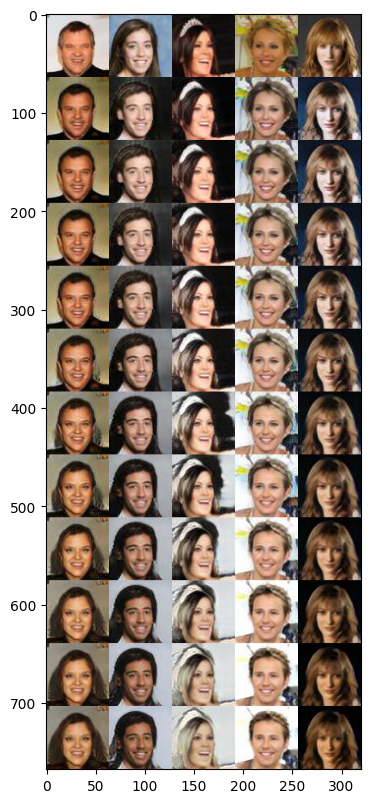

In [40]:
import torchvision.utils as vutils
import matplotlib.image as mpimg

x_real, _ = next(iter(val_loader))

imgs = [x_real.cpu()]

batch_size = x_real.shape[0]
x_real = x_real.to(device)
z_ref1, z_ref2 = torch.randn(batch_size * 2, latent_dim).to(device).chunk(2, dim=0)
y_trg1, y_trg2 = torch.randint(0, num_domains, (batch_size * 2,)).to(device).chunk(2, dim=0)

with torch.no_grad():
    s_trg1 = nets.mapping_network(z_ref1, y_trg1)
    s_trg2 = nets.mapping_network(z_ref2, y_trg2)

for i in range(11):
    s_trg = torch.lerp(s_trg1, s_trg2, i * 0.1)
    with torch.no_grad():
        x_fake = nets.generator(x_real, s_trg).cpu()
    imgs.append(x_fake)


imgs = torch.cat(imgs, dim=0)

imgs = ((imgs + 1) / 2).clamp_(0, 1)
vutils.save_image(imgs.cpu(), 'latent.jpg', nrow=batch_size, padding=0)
plt.figure(figsize=(10, 10), dpi=100)
img = mpimg.imread('latent.jpg')
imgplot = plt.imshow(img)
plt.show()

### Conclusions and possible improvements

I got 20k random male and 20k random female images from CelebA for training. For validation I got 200 random images for each gender. Validation images don't overlap with training images. <br>
I tried several different hyperparameters like latent vector size, step size of diversity sensitive weight, and others. However, results were worse when either mode collapse happened. That's why I used default parameters as in the paper.
We see some artifacts on images and sometimes borders are not sharp. It's because I trained models on images with smaller resolutions and few epochs. So if I train models on high-quality images with higher resolution and longer epochs the result should become better. Because after each epoch image quality becomes better and better. CelebA has low-quality images and this also affected negatively to have no sharp boundaries. <br> 
There is a difference between code and paper. In the paper they mention that they train style encoder on both reference images and latent vectors however in code we see that authors train style encoder only with latent vectors. However, in discussions, authors mentioned that when they trained the style encoder on reference images and latent vectors the results were highly degraded. I think the main problem, when the style encoder is also trained on reference images it has more training iterations compared to the mapping network and it breaks the balance, and as a result, the mapping network can't be trained well. In that case, authors forgot to optimize the code. Because of that, I added `with torch_grad()` when computing the loss of models which doesn't require updating weights after backpropagation, it reduced considerably the memory usage of RAM and increased the speed of computations.

Meme:<br>
<img src="https://imgur.com/r8qleHZ.png"/>